In [2]:
!pip install snntorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.1 MB/s eta 0:00:00


In [42]:

import snntorch as snn
from snntorch import surrogate

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from imblearn.over_sampling import SMOTE
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

In [43]:
df= pd.read_csv("star_classification.csv")
df.head(10)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237661e+18,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [45]:
df.isnull().sum()

,0
obj_ID,0
alpha,0
delta,0
u,0
g,0
r,0
i,0
z,0
run_ID,0
rerun_ID,0


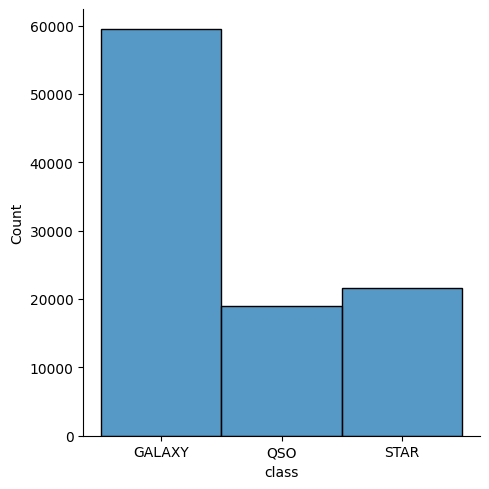

In [46]:
sns.displot(df["class"])
plt.show()

In [47]:
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

print("Class Labels:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Class Labels: {'GALAXY': 0, 'QSO': 1, 'STAR': 2}


In [48]:
corr_matrix = df.corr()
corr_matrix["class"].sort_values(ascending=False)

,class
class,1.000000
cam_col,0.023138
i,0.015028
delta,0.014452
MJD,-0.000405
z,-0.001614
plate,-0.010060
spec_obj_ID,-0.010060
alpha,-0.011756
g,-0.020066


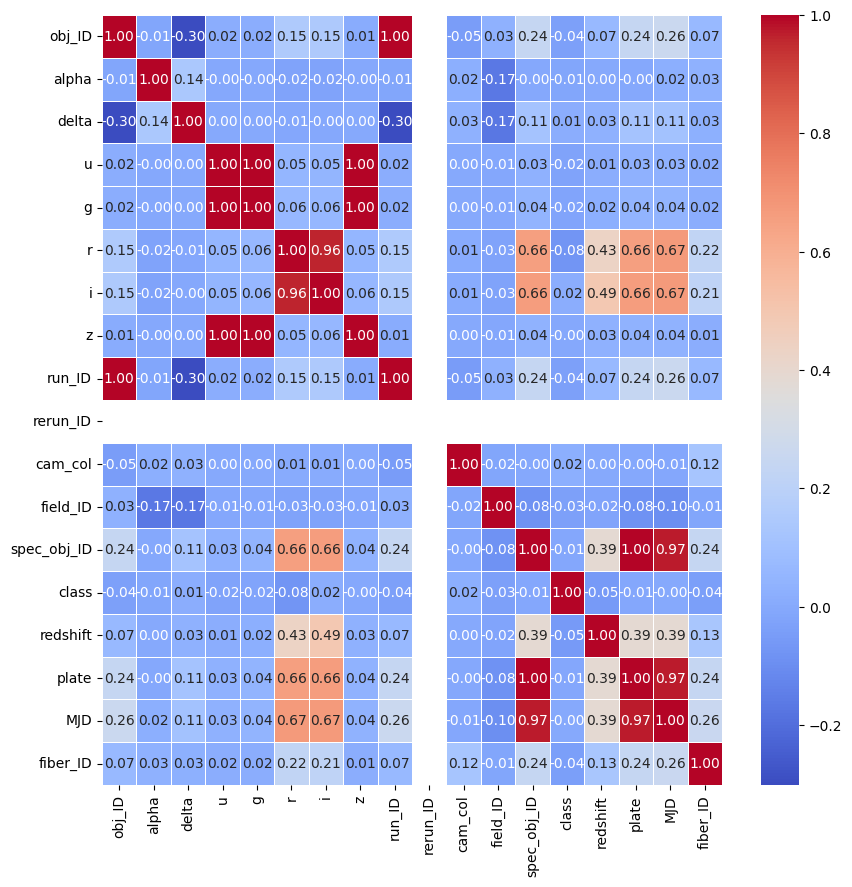

In [49]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot = True, fmt = ".2f", linewidths = .5, cmap='coolwarm')
plt.show()

In [50]:
df = df.drop(["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "fiber_ID"], axis=1)

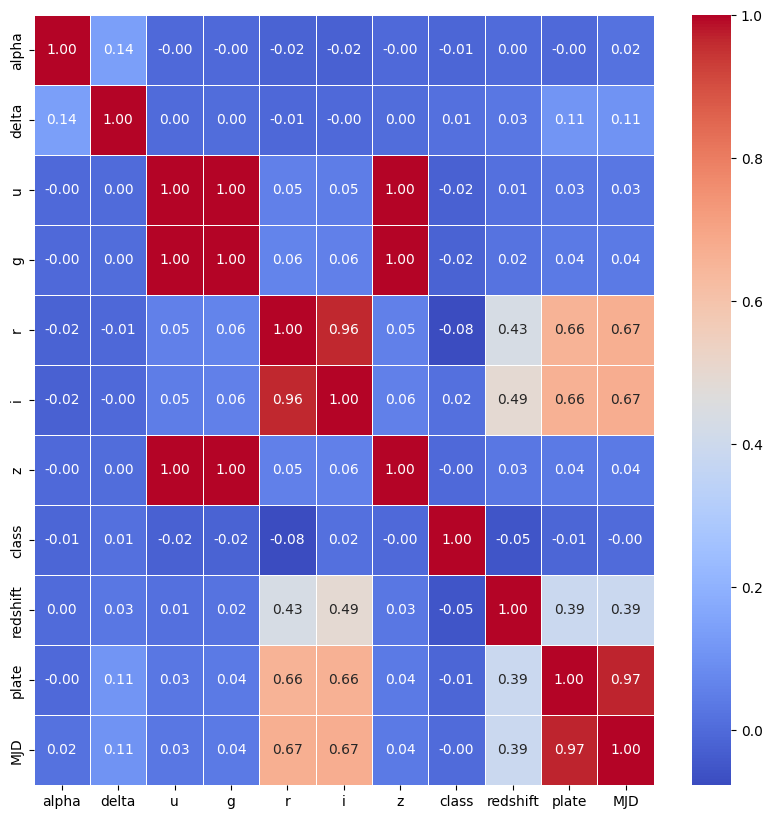

In [51]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot = True, fmt = ".2f", linewidths = .5, cmap='coolwarm')
plt.show()

In [52]:
df.columns

Index(['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'class', 'redshift', 'plate',
       'MJD'],
      dtype='object')

In [56]:
class CustomDataset(Dataset):
    def __init__(self, df, is_train=True, scaler=None, transform=None):
        self.is_train = is_train
        self.transform = transform

        if self.is_train:
            self.labels = df['class'].values
            self.features = df.drop(columns=['class']).values
        else:
            self.labels = None
            self.features = df.values

        if scaler:
            self.features = scaler.transform(self.features)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        if self.transform:
            feature = self.transform(feature)
        return {'feature': feature, 'label': label}


In [57]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(df_train.drop(columns=['class']))

train_dataset = CustomDataset(df_train, scaler=scaler)
test_dataset = CustomDataset(df_test, scaler=scaler)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [58]:
print(train_dataset[0])
print(train_dataset[0]['feature'].shape)
print(train_dataset[0]['label'].shape)

{'feature': array([-0.23360626,  0.78062858,  0.01023503,  0.0251797 ,  0.46647032,
        0.30829143,  0.01983167,  0.11297309, -0.19431063, -0.00950256]), 'label': 0}
(10,)
()


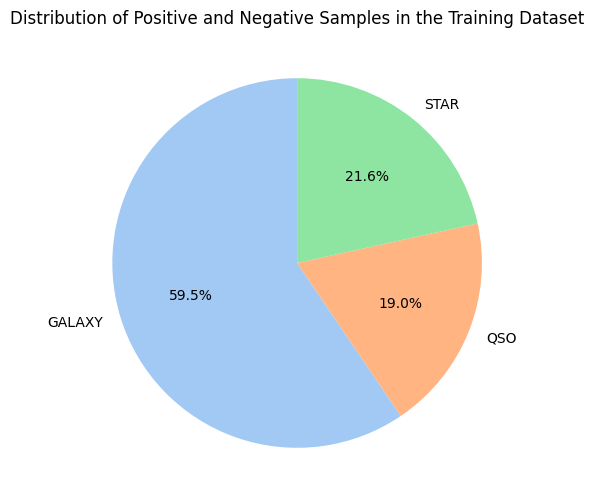

In [59]:
label_counts = np.bincount(train_dataset.labels)
label_names = ['GALAXY','QSO', 'STAR']

plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_names, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of Positive and Negative Samples in the Training Dataset')
plt.show()


In [60]:
smote = SMOTE(sampling_strategy='all')
train_dataset.features, train_dataset.labels = smote.fit_resample(train_dataset.features, train_dataset.labels)

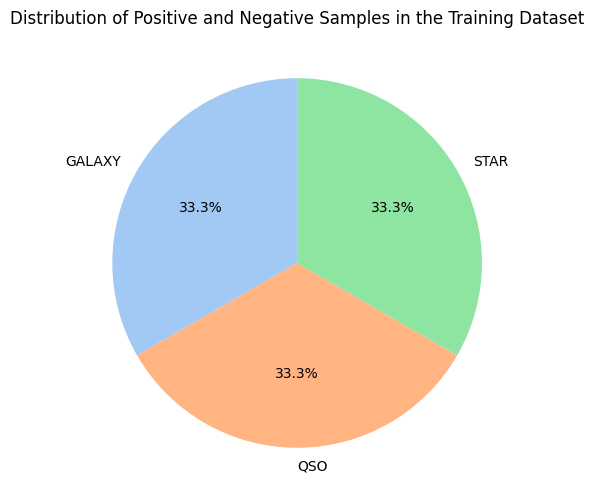

In [61]:
label_counts = np.bincount(train_dataset.labels)
label_names = ['GALAXY','QSO', 'STAR']

plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_names, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of Positive and Negative Samples in the Training Dataset')
plt.show()

In [62]:
batch_size = 64
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [63]:
print(train_dataset[0])
print(train_dataset[0]['feature'].shape)
print(train_dataset[0]['label'].shape)

{'feature': array([-0.23360626,  0.78062858,  0.01023503,  0.0251797 ,  0.46647032,
        0.30829143,  0.01983167,  0.11297309, -0.19431063, -0.00950256]), 'label': 0}
(10,)
()


In [64]:
for batch in train_dataloader:
    print(batch['feature'].shape)
    print(batch['label'].shape)
    break

torch.Size([64, 10])
torch.Size([64])


In [65]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(10, 10)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.fc2 = nn.Linear(10, 10)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.fc3 = nn.Linear(10, 3)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        cur1 = self.fc1(x)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = self.fc2(spk1)
        spk2, mem2 = self.lif2(cur2, mem2)
        cur3 = self.fc3(spk2)

        return cur3

device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)

model = Net().to(device)

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [67]:
results = pd.DataFrame(columns=['Epoch', 'Accuracy', 'Sensitivity', 'Specificity', 'AUC-ROC', 'Test Loss'])


In [69]:
for data in test_dataloader:
    print(data)
    break

{'feature': tensor([[-1.6661e+00, -1.0426e+00,  3.8768e-02,  4.0689e-02,  4.4948e-01,
          2.9469e-01,  1.3713e-02, -9.7024e-02, -2.7890e-01, -4.2115e-02],
        [ 6.4811e-01, -9.1595e-01, -1.1545e-01, -1.0471e-01, -1.7339e+00,
         -1.5793e+00, -6.7281e-02, -7.8852e-01, -1.0019e+00, -5.3904e-01],
        [-1.5216e+00, -1.1676e+00, -1.0619e-01, -1.0182e-01, -1.7384e+00,
         -1.6151e+00, -6.9346e-02, -7.8898e-01,  7.4288e-01,  6.0571e-01],
        [ 7.2623e-01, -6.7404e-01,  8.5645e-02,  3.3942e-02,  9.8299e-01,
          1.2632e+00,  7.4628e-02, -7.8939e-01, -3.6213e-01, -7.9149e-02],
        [-1.6459e+00, -1.4959e+00,  5.0910e-02,  3.6347e-02,  5.6477e-01,
          6.5371e-01,  3.7505e-02, -7.8918e-01,  9.3980e-01,  9.6389e-01],
        [ 5.3258e-02,  1.3864e+00,  1.3717e-02,  3.3164e-02,  3.2091e-01,
          1.8729e-01,  1.2341e-02, -1.0190e-01,  5.2093e-01,  4.4320e-01],
        [-2.8514e-01,  7.8038e-01, -8.4355e-02, -7.5490e-02, -1.2573e+00,
         -1.1869e+00

In [73]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for data in train_dataloader:
        inputs, labels = data['feature'].float(), data['label']
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []
        all_probs = []

        for data in test_dataloader:
            inputs, labels = data['feature'].float(), data['label']
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

            softmax = torch.nn.Softmax(dim=1)
            probabilities = softmax(outputs).cpu().numpy()
            all_probs.extend(probabilities)

        accuracy = 100 * correct / total
        cm = confusion_matrix(all_labels, all_predicted)

        print(f"Confusion Matrix Shape: {cm.shape}")
        print(cm)

        sensitivity_list = []
        specificity_list = []

        for i in range(cm.shape[0]):
            tp = cm[i, i]
            fn = cm[i, :].sum() - tp
            fp = cm[:, i].sum() - tp
            tn = cm.sum() - (tp + fp + fn)

            sensitivity = 100 * tp / (tp + fn) if (tp + fn) > 0 else 0.0
            specificity = 100 * tn / (tn + fp) if (tn + fp) > 0 else 0.0

            sensitivity_list.append(sensitivity)
            specificity_list.append(specificity)

            print(f"Class {i}: Sensitivity = {sensitivity:.2f}%  Specificity = {specificity:.2f}%")

        avg_sensitivity = sum(sensitivity_list) / len(sensitivity_list)
        avg_specificity = sum(specificity_list) / len(specificity_list)

        try:
            auc_roc = 100 * roc_auc_score(all_labels, all_probs, multi_class='ovr')
        except ValueError:
            auc_roc = 0.0

        print(
            f"Epoch [{epoch + 1}/{num_epochs}] Test Loss: {test_loss / len(test_dataloader):.2f} "
            f"Test Accuracy: {accuracy:.2f}% Avg Sensitivity: {avg_sensitivity:.2f}% Avg Specificity: {avg_specificity:.2f}% AUC-ROC: {auc_roc:.4f}%"
        )

        new_row = pd.DataFrame([{
            'Epoch': epoch + 1,
            'Accuracy': accuracy,
            'Sensitivity': avg_sensitivity,
            'Specificity': avg_specificity,
            'Test Loss': test_loss / len(test_dataloader),
            'AUC-ROC': auc_roc
        }])

        results = pd.concat([results, new_row], ignore_index=True)

Confusion Matrix Shape: (3, 3)
[[11407   139   294]
 [  472  3315     2]
 [   21     0  4318]]
Class 0: Sensitivity = 96.34%  Specificity = 93.93%
Class 1: Sensitivity = 87.49%  Specificity = 99.14%
Class 2: Sensitivity = 99.52%  Specificity = 98.11%
Epoch [1/20] Test Loss: 0.19 Test Accuracy: 95.35% Avg Sensitivity: 94.45% Avg Specificity: 97.06% AUC-ROC: 98.0742%


<ipython-input-73-5231df701687>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


Confusion Matrix Shape: (3, 3)
[[11270   154   416]
 [  413  3372     4]
 [   89     1  4249]]
Class 0: Sensitivity = 95.19%  Specificity = 93.82%
Class 1: Sensitivity = 88.99%  Specificity = 99.04%
Class 2: Sensitivity = 97.93%  Specificity = 97.31%
Epoch [2/20] Test Loss: 0.21 Test Accuracy: 94.61% Avg Sensitivity: 94.04% Avg Specificity: 96.73% AUC-ROC: 97.9442%
Confusion Matrix Shape: (3, 3)
[[11297   154   389]
 [  404  3383     2]
 [   11     0  4328]]
Class 0: Sensitivity = 95.41%  Specificity = 94.89%
Class 1: Sensitivity = 89.28%  Specificity = 99.05%
Class 2: Sensitivity = 99.75%  Specificity = 97.50%
Epoch [3/20] Test Loss: 0.20 Test Accuracy: 95.19% Avg Sensitivity: 94.82% Avg Specificity: 97.15% AUC-ROC: 98.2603%
Confusion Matrix Shape: (3, 3)
[[11402   179   259]
 [  374  3412     3]
 [    2     0  4337]]
Class 0: Sensitivity = 96.30%  Specificity = 95.37%
Class 1: Sensitivity = 90.05%  Specificity = 98.89%
Class 2: Sensitivity = 99.95%  Specificity = 98.32%
Epoch [4/20] 

In [74]:
results

,Epoch,Accuracy,Sensitivity,Specificity,AUC-ROC,Test Loss
0,1,95.352564,94.449675,97.060498,98.074216,0.193554
1,2,94.606370,94.035353,96.726158,97.944195,0.213602
2,3,95.192308,94.815036,97.146861,98.260310,0.197200
3,4,95.908454,95.434909,97.530424,98.413582,0.170012
4,5,96.148838,95.460835,97.586564,98.302816,0.166847
5,6,96.148838,95.825043,97.721348,98.611029,0.158269
6,7,94.711538,95.029012,97.111217,98.319504,0.201347
7,8,96.384215,95.785603,97.756731,98.608837,0.161691
8,9,96.569511,95.983763,97.866857,98.672299,0.146799
9,10,96.469351,95.807815,97.786079,98.553316,0.148098


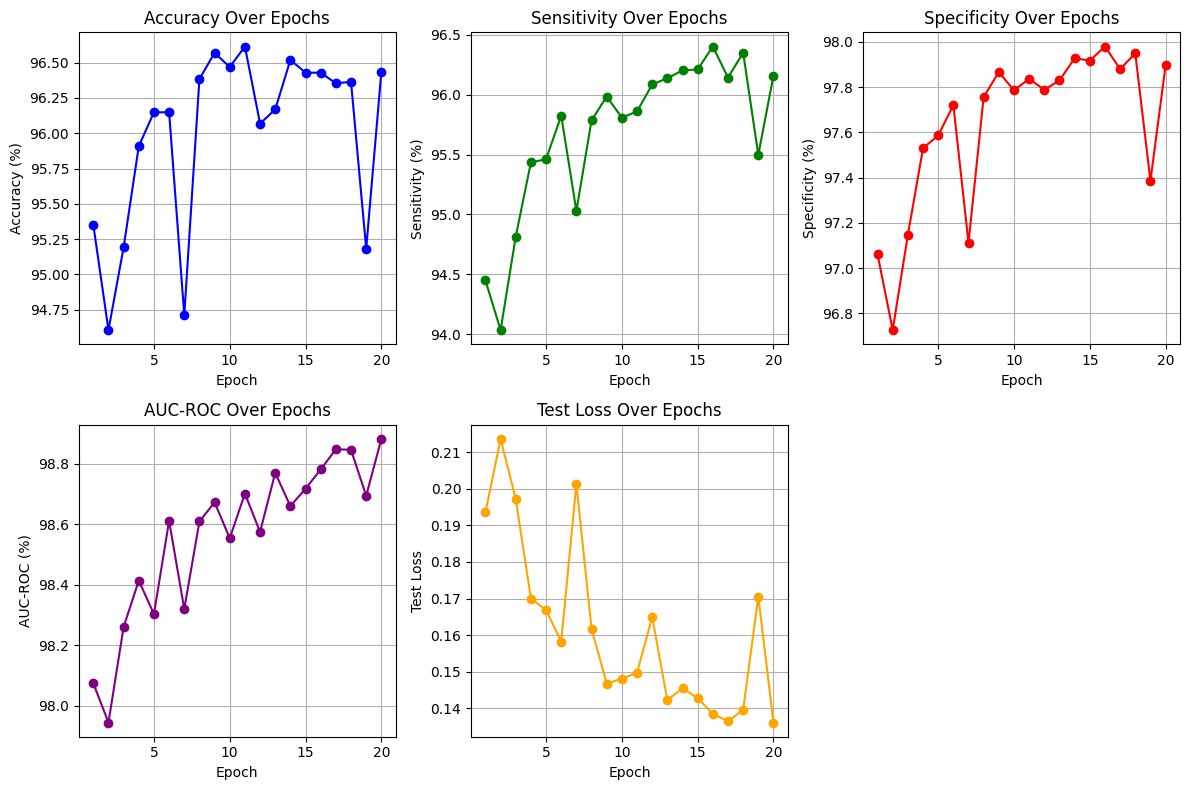

In [76]:
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 3, 1)
plt.plot(results['Epoch'], results['Accuracy'], marker='o', label='Accuracy', color='b')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

# Sensitivity
plt.subplot(2, 3, 2)
plt.plot(results['Epoch'], results['Sensitivity'], marker='o', label='Sensitivity', color='g')
plt.title('Sensitivity Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Sensitivity (%)')
plt.grid(True)

# Specificity
plt.subplot(2, 3, 3)
plt.plot(results['Epoch'], results['Specificity'], marker='o', label='Specificity', color='r')
plt.title('Specificity Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Specificity (%)')
plt.grid(True)

# AUC-ROC
plt.subplot(2, 3, 4)
plt.plot(results['Epoch'], results['AUC-ROC'], marker='o', label='AUC-ROC', color='purple')
plt.title('AUC-ROC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC (%)')
plt.grid(True)

# Test Loss
plt.subplot(2, 3, 5)
plt.plot(results['Epoch'], results['Test Loss'], marker='o', label='Test Loss', color='orange')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.grid(True)

plt.tight_layout()
plt.show()